In [5]:
import pickle

path = r"C:\Users\Arnav Jain\Desktop\cricket\bat_position\t20_decay\paceintents.bin"
with open(path, "rb") as f:
 pintents = pickle.load(f)

path = r"C:\Users\Arnav Jain\Desktop\cricket\bat_position\t20_decay\spinintents.bin"
with open(path, "rb") as f:
 sintents = pickle.load(f) 

path = r"C:\Users\Arnav Jain\Desktop\cricket\bat_position\t20_decay\pacefshots.bin"
with open(path, "rb") as f:
 pfshots = pickle.load(f)

path = r"C:\Users\Arnav Jain\Desktop\cricket\bat_position\t20_decay\spinfshots.bin"
with open(path, "rb") as f:
 sfshots = pickle.load(f)  

In [23]:
pfshots['Sanju Samson']

{'batshots': [15.157557782581701,
  18.134680130976047,
  11.621734460758772,
  19.993468605041876,
  14.658279111711874,
  11.417827112806748,
  5.5087445454288915,
  5.374374014601763,
  3.821529355750271,
  5.604357807681631,
  7.459165668349349,
  6.22329774922261,
  9.090074048861112,
  10.833380207905117,
  7.086823038863283,
  5.796240104212943,
  7.9210604061723995,
  8.758829161054408,
  4.757744143959806,
  6.8272245939526295],
 'othbatshots': [24.58587756733177,
  23.803212412407703,
  19.125434823022427,
  18.970977179485335,
  26.708483276807485,
  19.771141573850418,
  8.397075691623044,
  6.059611986653041,
  11.84829748010658,
  9.128609436749322,
  11.225175532688215,
  12.417873422946602,
  9.505071385554265,
  13.050208667949637,
  10.155791837754277,
  9.910887804293512,
  6.550752537325901,
  7.579260798392578,
  7.776334923149923,
  5.5134397858120066],
 'batballs': [55.20446269438858,
  64.60922134811244,
  44.79498776999553,
  80.97099337942822,
  66.15952494079

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import math
from typing import List, Dict

# ---------- helpers ----------

def _safe_sum_series(d, keys):
    return float(sum(d[k] for k in keys))

def _ratio(num, den):
    den = float(den)
    return float(num) / den if den > 0 else 0.0

def _aggregate_for_batter(
    intent_dict_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    fshot_dict_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    batter: str,
    i_keys
):
    """
    Compute intent, fshot, int-rel for a single batter over i_keys.
    intent = (sum batruns / sum batballs) / (sum othbatruns / sum othbatballs)
    fshot  = (sum batshots / sum batballs) / (sum othbatshots / sum othbatballs)
    int-rel = intent / sqrt(fshot)
    """
    bd_int = intent_dict_by_batter.get(batter, {})
    bd_fsh = fshot_dict_by_batter.get(batter, {})

    # Intent sums
    sum_batruns     = _safe_sum_series(bd_int.get('batruns', {}), i_keys)
    sum_batballs    = _safe_sum_series(bd_int.get('batballs', {}), i_keys)
    sum_othbatruns  = _safe_sum_series(bd_int.get('othbatruns', {}), i_keys)
    sum_othbatballs = _safe_sum_series(bd_int.get('othbatballs', {}), i_keys)

    br_rate  = _ratio(sum_batruns, sum_batballs)
    oth_rate = _ratio(sum_othbatruns, sum_othbatballs)
    intent = _ratio(br_rate, oth_rate)

    # Fshot sums
    sum_batshots    = _safe_sum_series(bd_fsh.get('batshots', {}), i_keys)
    sum_othbatshots = _safe_sum_series(bd_fsh.get('othbatshots', {}), i_keys)

    # Denominators for fshot
    if isinstance(bd_fsh.get('batballs', None), dict):
        sum_f_batballs = _safe_sum_series(bd_fsh.get('batballs', {}), i_keys)
    else:
        sum_f_batballs = sum_batballs if sum_batballs > 0 else 1.0

    if isinstance(bd_fsh.get('othbatballs', None), dict):
        sum_f_othbatballs = _safe_sum_series(bd_fsh.get('othbatballs', {}), i_keys)
    else:
        sum_f_othbatballs = sum_othbatballs if sum_othbatballs > 0 else 1.0

    br_shot_rate  = _ratio(sum_batshots, sum_f_batballs)
    oth_shot_rate = _ratio(sum_othbatshots, sum_f_othbatballs)
    fshot = _ratio(br_shot_rate, oth_shot_rate)

    sqrt_fshot = math.sqrt(fshot) if fshot > 0 else float('inf')
    int_rel = intent / sqrt_fshot if np.isfinite(sqrt_fshot) and sqrt_fshot > 0 else 0.0

    return intent, fshot, int_rel

# ---------- main computation for requested interface ----------

def int_rel_by_batter_phase(
    pintents_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    pfshots_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    sintents_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    sfshots_by_batter: Dict[str, Dict[str, Dict[int, float]]],
    batters: List[str],
    start_over: int,
    end_over: int
):
    """
    Inputs: start_over, end_over (inclusive), and list of batters.
    Output: DataFrame with per-batter pace_int_rel, spin_int_rel, avg_int_rel (rounded to 2 decimals).
    Uses i in [start_over-1, end_over-1] inclusive.
    """
    if isinstance(batters, str):
        batters = [batters]

    i_keys = list(range(int(start_over) - 1, int(end_over)))
    print(i_keys)

    rows = []
    for batter in batters:
        # pace
        _, _, p_int_rel = _aggregate_for_batter(pintents_by_batter, pfshots_by_batter, batter, i_keys)
        # spin
        _, _, s_int_rel = _aggregate_for_batter(sintents_by_batter, sfshots_by_batter, batter, i_keys)
        # mean
        avg = np.nanmean([p_int_rel, s_int_rel])

        rows.append({
            'batter': batter,
            'pace_int_rel': round(p_int_rel, 2),
            'spin_int_rel': round(s_int_rel, 2),
            'avg_int_rel': round(avg, 2)
        })

    df = pd.DataFrame(rows, columns=['batter', 'pace_int_rel', 'spin_int_rel', 'avg_int_rel'])
    return df

# ---------- optional minimalistic table renderer ----------

def render_int_rel_table(df: pd.DataFrame, title='Int-Rel (Pace/Spin) — Selected Batters, Phase'):
    """
    Render a minimal, zebra-striped table from the df produced by int_rel_by_batter_phase.
    """
    disp = df.copy()
    # ensure 2-decimal strings
    for col in ['pace_int_rel', 'spin_int_rel', 'avg_int_rel']:
        if col in disp.columns:
            disp[col] = disp[col].map(lambda x: f"{x:.2f}" if pd.notna(x) and np.isfinite(x) else "–")

    n_rows, n_cols = disp.shape
    fig_width = 7 if n_cols <= 4 else 9
    fig_height = max(1.5, 0.6 * (n_rows + 1))
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')

    table = Table(ax, bbox=[0, 0, 1, 1])

    col_w = 1.0 / n_cols
    row_h = 1.0 / (n_rows + 1)

    header_face = (0.12, 0.12, 0.12)
    header_text = 'white'
    row_face_1 = (0.98, 0.98, 0.98)
    row_face_2 = (0.93, 0.93, 0.93)
    text_color = (0.1, 0.1, 0.1)

    # Header
    for j, col in enumerate(disp.columns):
        cell = table.add_cell(0, j, col_w, row_h,
                              text=col.replace('_', ' ').title(),
                              facecolor=header_face, edgecolor='none', loc='center')
        try:
            cell.set_text_props(color=header_text, fontsize=11, weight='bold')
        except Exception:
            t = cell.get_text()
            t.set_color(header_text)
            t.set_fontsize(11)
            t.set_weight('bold')

    # Rows
    for i in range(n_rows):
        face = row_face_1 if i % 2 == 0 else row_face_2
        for j, col in enumerate(disp.columns):
            txt = str(disp.iloc[i, j])
            ha = 'left' if j == 0 else 'right'
            cell = table.add_cell(i + 1, j, col_w, row_h,
                                  text=txt, facecolor=face, edgecolor='none', loc='center')
            try:
                cell.set_text_props(color=text_color, fontsize=10, ha=ha, va='center', family='DejaVu Sans')
            except Exception:
                t = cell.get_text()
                t.set_color(text_color)
                t.set_fontsize(10)
                t.set_horizontalalignment(ha)
                t.set_verticalalignment('center')
                t.set_family('DejaVu Sans')

    ax.add_table(table)
    ax.set_title(title, loc='left', pad=10, fontsize=13, fontweight='bold', color=(0.1, 0.1, 0.1))
    plt.tight_layout()
    return fig



[16, 17, 18, 19]
           batter  pace_int_rel  spin_int_rel  avg_int_rel
0    Sanju Samson          1.05          0.97         1.01
1   Hardik Pandya          1.14          0.95         1.05
2     Rinku Singh          1.28          1.63         1.46
3  Shashank Singh          1.30          2.13         1.71
4   Jitesh Sharma          1.19          0.88         1.04
5      Axar Patel          0.95          1.27         1.11


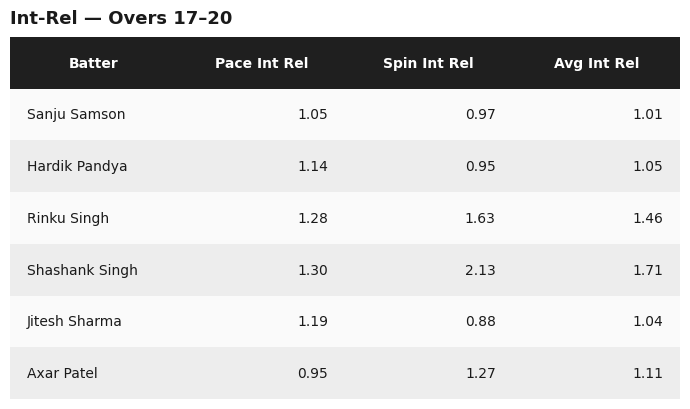

In [ ]:
# Example: compute phase 1–6 for selected batters
batters_list = ["Sanju Samson"]
start = 1
end = 6
df_phase = int_rel_by_batter_phase(
    pintents_by_batter=pintents,
    pfshots_by_batter=pfshots,
    sintents_by_batter=sintents,
    sfshots_by_batter=sfshots,
    batters=batters_list,
    start_over=start,
    end_over=end
)
print(df_phase)

# Optional: render minimalistic table
fig = render_int_rel_table(df_phase, title=f'Int-Rel — Overs {start}–{end}')
plt.show()

